# REINFORCE with Baseline

Now that you have learned about [Policy Networks](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Policy%20Networks/policy_networks.ipynb) its time to solve some of its problems. The main issue is that our trajectories $G_t$ are very high variance! So we will solve this with our REINFORCE with Baseline (also sometimes known as Vanilla Policy Gradient or VPG, but I think this naming makes it confusing)

### Noisy Returns

In our implementation, we first interact with the environment to sample a trajectory. After that we can take the rewards we got at every step and then compute our $G_t$ returns. The problem is this:

1) Our environment is typically stochastic and our states have some randomness built in
2) Initially our Policy Network isn't good so we have randomness in our Action selection

All this randomness between the environment and our reaction to the environment adds up, and leads to noisy returns. The problem here is that the return signal we are providing our Neural Network to learn from (to select actions that maximize returns) is high variance and difficult to interpret. Therefore we need to something different.

#### Intuition

Lets say you are learning to shoot arrows. And as you shoot arrows there is a lot of wind. There are two areas for randomness here:

1) I dont know how to shoot arrows, I may do something slighly different every time
2) The wind injects more randomness into the environment, so even with exactly the same action I may get different results

Our Policy Gradient is like this. It is trying to learn from how I shoot arrows, but due to all the randomness, it cannot easily separate out good and bad actions in even the same state. 

Now what if we had a wind gauge? It tells us exactly what the wind is doing. This would give me a better idea of how to shoot my arrow to better get on target! 

This is exactly what we need. If we had some estimate of the Value of a state, then we know more or less everything we need about it (its an average after all). Then all I need to focus on is if the different actions at that state improve or hurt my rewards!

Wait... this sounds familiar doens't it? Yes! We did this in [Dueling DQN](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Dueling%20Deep-Q%20Learning/dueling_deep_q_learning.ipynb)!

### Advantage Function

In our Dueling DQN, instead of just learning some $Q(s,a)$ directly, we represented it as:

$$Q(s,a) = V(s) + A(s,a)$$ 

Our $Q(s,a)$ estimate was the sum of the Value of a state and the Advantage of taking an action at a specific state. The advantage sounds like what we need right? Lets rewrite it:

$$A(s,a) = Q(s,a) - V(s)$$ 

The advantage directly quantifies the benifit of taking one action over the others. Remember that V(s) is the average value across all actions, so this is really the difference between the $Q$ value for an action and the average $Q$ value across all the actions. In our case, we are using $G_t$ instead of $Q$ but the same reasoning holds!

### Updating our Policy Gradient Formula

Here was our final formula for the Policy Gradient:

$$\nabla_\theta J(\theta) = E_{\pi} \left[G_t\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Where $G_t$ is our returns. Technically the way we implement this we add an extra sum over the trajectory timesteps so we sum up the contributions of each timestep:

$$\nabla_\theta J(\theta) = E_{\pi} \left[\sum_{t=0}^{T-1}G_t\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Our goal is to maximize this, just like before, but as we know, $G_t$ is a high variance target. So instead, of trying to maximize our total returns, what if we tried to maximize our Advantage?

$$\nabla_\theta J(\theta) = E_{\pi} \left[\sum_{t=0}^{T-1}A(s,a)\nabla_\theta \ln\pi_\theta(a|s)\right]$$
$$ E_{\pi} \left[\sum_{t=0}^{T-1}(G_t - V(s_t))\nabla_\theta \ln\pi_\theta(a|s)\right]$$

This means we now have two networks going on:

1) **Policy Network** determines the action we should take at a state, same as before!
2) **Value Network** determines the value of a state. Is trained to predict the value function $V(s)$ which is the estimate of the returns from different states. To do this we can just use Mean Squared Error (or L1, Huber, etc...) between our predictions and the targets gathered from our experiences.

#### Side Note 1: Do we need a Value Network?

No! We could use a running average or something else for the Values. But in this case we will use a Neural Network to approximate it

#### Side Note 2: Is This Actor Critic?

So we haven't talked about Actor Critic yet, but this is a common question. The entire point of our Policy Network was that we didn't compute the values, but here we are yet again doing it. There are three umbrellas of models:

1) Value-Based Models (DQN, Double DQN, Dueling DQN, ...)
2) Policy-Based Models (Policy Networks, ...)
3) Actor-Critic Models (Value + Policy)

I would personally think think REINFORCE with Baseline is an Actor-Critic because we are estimating both the Policy and the Value functions, but [**Rich Sutton**](https://en.wikipedia.org/wiki/Richard_S._Sutton) one of the fathers of RL and the writer of one of the most important books [Reinforcement Learning: An Introduction](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) would disagree. On page 10 of the book you will find its says:

*Methods like this, called **policy gradient methods**, have proven useful in many problems, and some of the simplest reinforcement learning methods fall into this category. In fact, some of these methods take advantage of value function estimates to improve their gradient estimates. Overall, the distinction between policy gradient methods and other methods we include as reinforcement learning methods is not sharply defined.*

So by this definition, what we are doing is still Policy Gradient, or maybe an Action-Value method? This has nothing to do with our understanding of whats going on, its just the lines are not clearly defined. 

I think the right way to think about this is in our setup, the Value function is used to compute an Advantage. In the Actor-Critic setup the actor (policy network) chooses the action and the critic then evaluates that action taken, which is different. Either way we are splitting hairs here, its a definition thing anyway!

### Lets Build it!

The first step is to create our two networks, Policy and Value Network. The Policy Network will be the same as before! The action network will have an output for however many actions it has to select between. The value network will output a single number as we just a one number estimate of the values. 

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Video

class PolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi

class ValueNetwork(nn.Module):
    def __init__(self, input_state_features=8, hidden_features=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value
        

### Compute Returns

Computing the returns from our trajector is identical to before!

In [2]:
def compute_returns(reward_trajectory, gamma=0.99):
    ### Initialize Returns ###
    returns = []
    G_t = 0

    ### Reverse and Compute Returns ###
    for r_t in reversed(reward_trajectory):
        G_t = r_t + gamma * G_t
        returns.insert(0, G_t)

    return torch.tensor(returns, dtype=torch.float32)

### Train our Model

This is mostly identical to before but we have a few changes:

1) We have two models that both have to be optimized, so we can also define two optimizers.
2) Instead of using $G_t$ directly, we will compute our advantage $A(s,a) = G_t - V(s)$ 

In [3]:
def train(env, 
          input_state_features=8, 
          num_actions=4,
          hidden_features=128,
          learning_rate=0.0005,
          episodes=5000, 
          running_avg_steps=10, 
          print_freq=50,
          gamma=0.99,
          device="cpu"):

    policy_network = PolicyNetwork(
        input_state_features=input_state_features, 
        num_actions=num_actions,
        hidden_features=hidden_features
    ).to(device)
    
    p_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)

    ##############################
    ### CREATE VALUE NETWORK #####
    value_network = ValueNetwork(
        input_state_features=input_state_features, 
        hidden_features=hidden_features
    ).to(device)

    ### CREATE VALUE OPTIMIZER ###
    v_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate)
    ##############################

    log = {"scores": [], 
           "running_avg_scores": []}
    
    for i in range(episodes):

        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        ###################
        ### STORE VALUES###
        values = []
        ###################
        
        while not done:

            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            
            action_probs = policy_network(state)
            
            selected_action = torch.multinomial(action_probs, num_samples=1).item()
            
            log_prob = torch.log(action_probs[0, selected_action])

            ##########################
            ### GET VALUE OF STATE ###
            value = value_network(state)

            ### Store Value ###
            values.append(value)
            ##########################
            
            next_state, reward, terminal, truncated, _ = env.step(selected_action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            
            done = terminal or truncated
            
            state = next_state


        returns = compute_returns(rewards, gamma).to(device)
    
        ##########################
        ### CONVERT TO TENSORS ###
        values = torch.cat(values, dim=0).squeeze()
        
        ### COMPUTE ADVANTAGES (DONT WANT GRAD BTWN POLICY AND VALUE NETWORKS) ###
        advantages = returns - values.detach()

        ### NORMALIZE ADVANTAGES ###
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        ### COMPUTE POLICY GRADIENT LOSS ###
        policy_loss = -torch.sum(torch.stack(log_probs) * advantages)

        ### COMPUTE VALUE NETWORK LOSS ###
        value_loss = F.mse_loss(values, returns)

        ### UPDATE Policy Model ###
        p_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
        p_optimizer.step()

        ### UPDATE Value Model ###
        v_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
        v_optimizer.step()
        
        ##########################

        ### Store Total Reward for Episode ###
        total_rewards = sum(rewards)

        ### Log ###
        log["scores"].append(total_rewards)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)

        if i % print_freq == 0:
            print(f"Episode {i}, Total Reward: {total_rewards}, Average Reward: {running_avg_score}")

    return policy_network, value_network, log

### Play Game ###
env = gym.make("LunarLander-v3", render_mode="rgb_array")
policy_network, value_network, log = train(env, device="cuda")
        

Episode 0, Total Reward: -187.61705492348122, Average Reward: -187.61705492348122
Episode 50, Total Reward: -143.81804401776355, Average Reward: -162.07386867193196
Episode 100, Total Reward: -166.54269963499144, Average Reward: -144.11066066417203
Episode 150, Total Reward: -94.56563528524646, Average Reward: -172.13310182735958
Episode 200, Total Reward: -136.78577307760577, Average Reward: -130.7553019808976
Episode 250, Total Reward: -12.493887498210242, Average Reward: -106.89605725927841
Episode 300, Total Reward: -244.4959135026037, Average Reward: -79.19376044121684
Episode 350, Total Reward: -322.2272008154716, Average Reward: -211.5014341533637
Episode 400, Total Reward: -207.20668587290896, Average Reward: -35.418093041244305
Episode 450, Total Reward: -23.160670345036877, Average Reward: -122.58681114056071
Episode 500, Total Reward: -89.26235467514489, Average Reward: -121.9944290113219
Episode 550, Total Reward: 2.1581946895707205, Average Reward: -1.8420507764338367
Epis

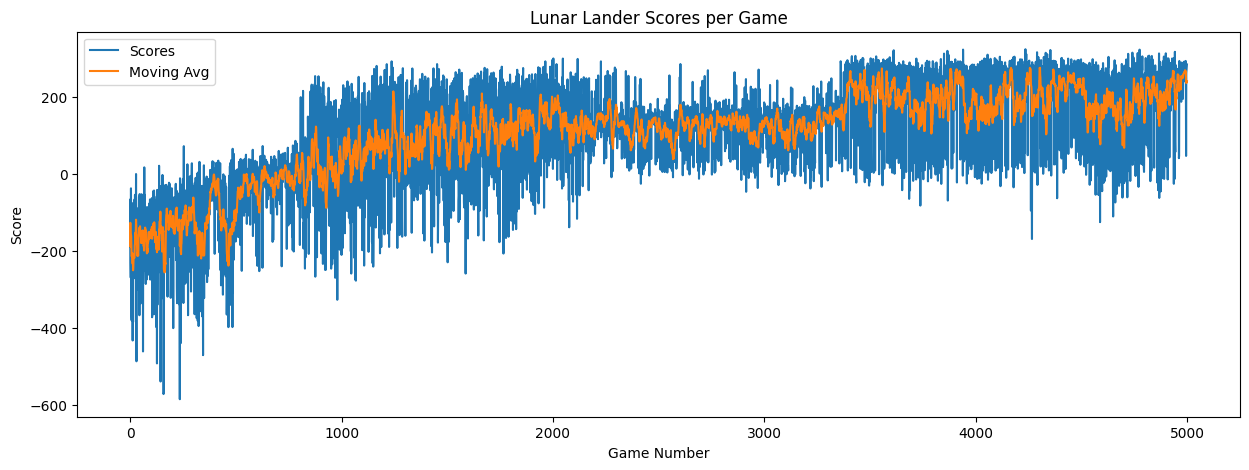

In [4]:
plt.figure(figsize=(15,5))
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

In [10]:
def record_game(env, policy, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset(seed=42)
    
    while not done:

        ### Get Predicted Action ###
        action = policy(torch.tensor(state, device=device).unsqueeze(0)).argmax(axis=-1).item()

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

record_game(env, policy_network, prefix="policy-network-baseline")

Video("savevideos/policy-network-baseline-episode-0.mp4", embed=True)